# Data Loading and Preprocessing

Import necessary libraries and load the image files.


---




In [1]:
#Import necessary libraries.
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib.image import imread
import cv2
import json
from sklearn.model_selection import train_test_split 

In [2]:
#Connect with your personal Google Drive.
import google.colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
#Load .json data file.
f = open(r'/content/drive/MyDrive/Projects/Python_Projects/Ship_Classification_in_Satellite_Images_Keras/shipsnet.json')
dataset = json.load(f)
f.close()
print('The above dataset is in "{}" type'.format(type(dataset)))

The above dataset is in "<class 'dict'>" type


In [6]:
dataset.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [7]:
locations = pd.DataFrame(dataset['locations'], columns=["λ","φ"])
locations.head()

,λ,φ
0,-118.225469,33.738037
1,-122.332229,37.749176
2,-118.142831,33.736016
3,-122.347843,37.766487
4,-122.348524,37.758785


In [8]:
scene_ids = pd.DataFrame(dataset['scene_ids'], columns=[" Scene ID"])
scene_ids.head(5)

,Scene ID
0,20180708_180909_0f47
1,20170705_180816_103e
2,20180712_211331_0f06
3,20170609_180756_103a
4,20170515_180653_1007


In [9]:
input_data = np.array(dataset['data']).astype('uint8')
input_targets = np.array(dataset['labels']).astype('uint8')

In [10]:
#Create a 3d data tensor with red channels of all input images.
stack = np.zeros(shape=(80,80))
for image in range(0,input_data.shape[0]): 
  newimage = input_data[image,:].reshape(3,80,80)[0]
  stack = np.dstack((stack,newimage))
X_data = stack[:,:,1:]

In [11]:
#Change the shape of data tensor from (80,80,4000) to (4000,80,80)
X_data_2 = np.zeros(shape=(input_data.shape[0],80,80))
for i in range(0,input_data.shape[0]): 
  X_data_2[i,:,:] = X_data[:,:,i]
X = X_data_2
print("Created data tensor has size of {} x {} x {} voxels.".format(X.shape[0],X.shape[1],X.shape[2]))

Created data tensor has size of 4000 x 80 x 80 voxels.


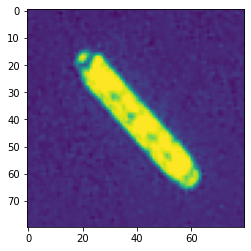

In [36]:
#Show the 1st image from the 3d data tensor X.
plt.imshow(X[0,:,:]);

In [ ]:
#Normalize the data in the interval [0,1]
maxval = np.amax(X)
X = X/maxval
if np.amax(X)<=1: print("Data tensor normalized successfully")

In [ ]:
y = input_targets
if X.shape[0]==y.shape[0]: print('Train and test tensors are in correct shape')
#Convert catecory numbers to categorical variables because the model will assume that they are continious numbers.
y = tf.keras.utils.to_categorical(y)

Split the data to train and test sets.

---



In [ ]:
indices = np.arange(4000)
X_train, X_test, y_train, y_test, train_idxs, test_idxs= train_test_split( X, y, indices, test_size=0.33, random_state=42)

Reshape the data tensors into 4 dimensional tensors (Images x width x height x number of channels )

---

In [ ]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [ ]:
if len(X_train.shape)==len(X_test.shape) and len(X_test.shape)==4: print("Train end test tensors are in correct shape")

#Build and train the model.

---



Build the model.

---



In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, Input, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
i = Input(shape=X_train[0].shape)
x = Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='valid', activation='relu')(i)
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='valid', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='valid', activation='relu')(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(i,x)

Compile the model and fit it in the train data.

---



In [ ]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
y_train2=y_train[:,1]

In [ ]:
#r = model.fit(x=X_train, y=y_train2, batch_size=None, epochs=15, verbose=1, callbacks=[earlystopping], validation_split=0.05)

Epoch 1/15
80/80 [==============================] - 9s 112ms/step - loss: 0.8134 - accuracy: 0.8661 - val_loss: 0.1651 - val_accuracy: 0.9254
Epoch 2/15
80/80 [==============================] - 9s 107ms/step - loss: 0.1380 - accuracy: 0.9466 - val_loss: 0.1540 - val_accuracy: 0.9478
Epoch 3/15
80/80 [==============================] - 9s 106ms/step - loss: 0.0912 - accuracy: 0.9701 - val_loss: 0.0893 - val_accuracy: 0.9776
Epoch 4/15
80/80 [==============================] - 9s 107ms/step - loss: 0.0552 - accuracy: 0.9808 - val_loss: 0.1112 - val_accuracy: 0.9478
Epoch 5/15
80/80 [==============================] - 9s 107ms/step - loss: 0.0505 - accuracy: 0.9808 - val_loss: 0.0786 - val_accuracy: 0.9701
Epoch 6/15
80/80 [==============================] - 9s 107ms/step - loss: 0.0197 - accuracy: 0.9918 - val_loss: 0.0963 - val_accuracy: 0.9627
Epoch 7/15
80/80 [==============================] - 9s 107ms/step - loss: 0.0239 - accuracy: 0.9914 - val_loss: 0.0780 - val_accuracy: 0.9776
Epoch 

Plot loss and accuracy for both train and test data.

---



In [ ]:
#Save the final model, once training is completed.
#model_name = '/content/drive/My Drive/Projects/Python_Projects/CNN/Ship_Detection_CNN.h5'
#model.save(model_name)

#Model Evaluation.

---



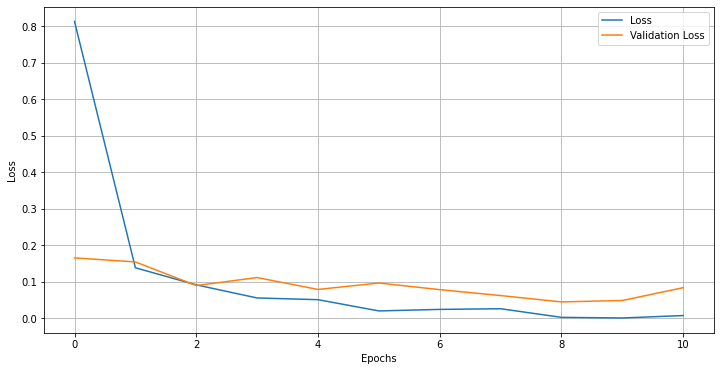

In [ ]:
plt.figure(figsize=(12,6))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(r.history['loss'], label="Loss")
plt.plot(r.history['val_loss'], label="Validation Loss")
plt.legend();

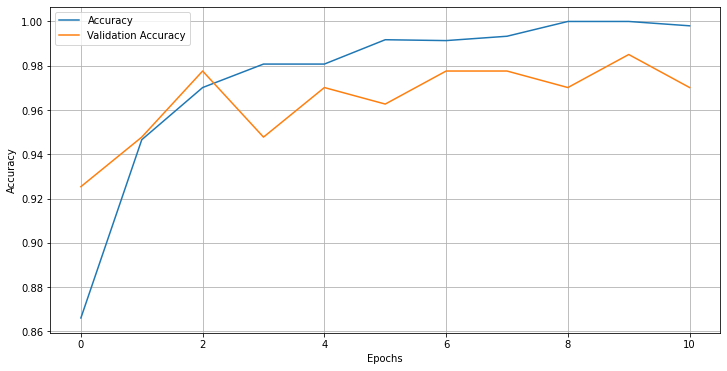

In [ ]:
plt.figure(figsize=(12,6))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(r.history['accuracy'], label="Accuracy")
plt.plot(r.history['val_accuracy'], label="Validation Accuracy")
plt.legend();

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Projects/Python_Projects/CNN/Ship_Detection_CNN.h5')
ypred = model.predict(X_test)

In [ ]:
ypred = ypred > 0.5

In [ ]:
#Make a dataframe with true and predicted values.
y_all = np.concatenate((y_test[:,1].reshape(-1,1), ypred[:,1].reshape(-1,1)), axis=1)
df = pd.DataFrame(y_all, columns=["True Label","Predicted Label"], index=test_idxs)
df.head()

,True Label,Predicted Label
555,1.0,1.0
3491,0.0,0.0
527,1.0,1.0
3925,0.0,0.0
2989,0.0,0.0


In [ ]:
df = df.sort_index()
df["Scene id"] = scene_ids.loc[test_idxs].sort_index()
df["Image center longitude"] = locations["λ"].loc[test_idxs].sort_index()
df["Image center latitude"] = locations["φ"].loc[test_idxs].sort_index()
df.head()
df.to_csv("/content/drive/My Drive/Projects/Python_Projects/CNN/y_locations_and_scenes.csv")

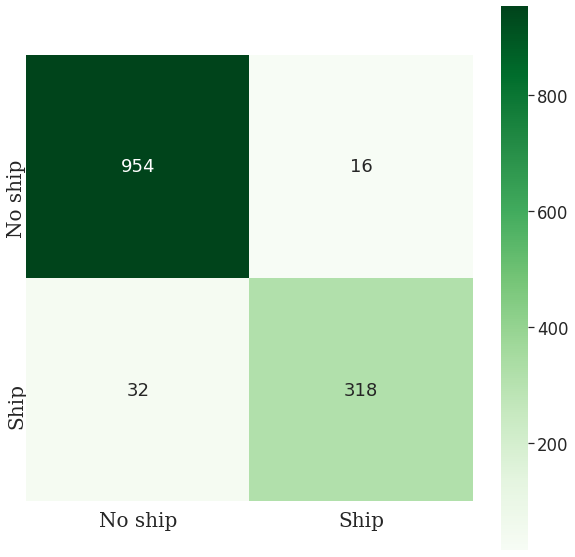

In [ ]:
import sklearn as skl
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.heatmap(skl.metrics.confusion_matrix(y_true=df["True Label"], y_pred=df['Predicted Label']), annot=True, square=True, fmt='g', cmap="Greens")
plt.yticks(ticks=[0.5,1.5], labels=["No ship","Ship"], size=20, family="serif", ha="center")
plt.xticks(ticks=[0.5,1.5], labels=["No ship","Ship"], size=20, family="serif", ha ="center");

In [ ]:
print(skl.metrics.classification_report(y_true=y_test[:,1], y_pred=ypred[:,1]))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       970
         1.0       0.95      0.91      0.93       350

    accuracy                           0.96      1320
   macro avg       0.96      0.95      0.95      1320
weighted avg       0.96      0.96      0.96      1320



#Detected ships visualization

---



In [14]:
#Read saved .csv.
detected_ships_df = pd.read_csv('/content/drive/MyDrive/Projects/Python_Projects/Ship_Classification_in_Satellite_Images_Keras/y_locations_and_scenes.csv', index_col=0)

In [15]:
#Find correctly classified ships.
detected_ships_df = detected_ships_df.loc[(detected_ships_df['True Label']==detected_ships_df['Predicted Label']) & (detected_ships_df['True Label']==1)]

In [16]:
#Show the first 5 ships from the new dataframe.
detected_ships_df.head()

,True Label,Predicted Label,Scene id,Image center longitude,Image center latitude
0,1.0,1.0,20180708_180909_0f47,-118.225469,33.738037
7,1.0,1.0,20170508_180611_1010,-122.351587,37.747364
8,1.0,1.0,20170703_180945_1009,-122.346954,37.739848
12,1.0,1.0,20170723_180812_1005,-122.325792,37.726750
14,1.0,1.0,20180708_182358_1032,-122.346815,37.759451


In [17]:
#Select ramdomly 20 correct classified ships.
random_ships = np.random.choice(detected_ships_df.index, size=20)

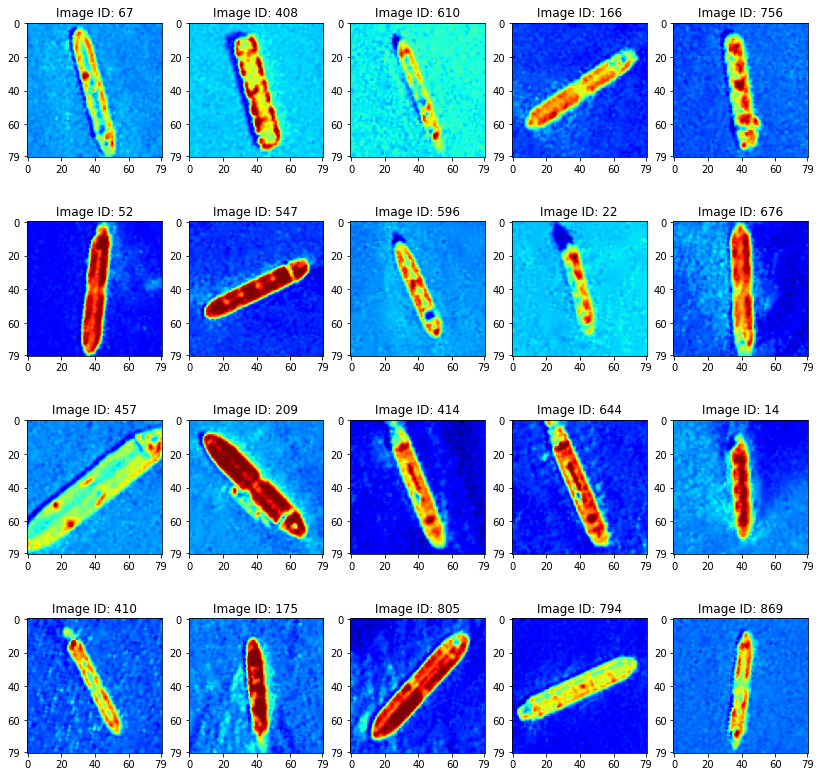

In [34]:
#Plot 20 correct classified ships. (true positives)
w=10
h=10
fig=plt.figure(figsize=(14, 14))
columns = 5
rows = 4
tickpos = [0,20,40,60,79]
for i in range(1, columns*rows +1):
    img = X[random_ships[i-1],:,:]
    fig.add_subplot(rows, columns, i)
    plt.title("Image ID: {}".format(random_ships[i-1]))
    plt.imshow(img, cmap="jet")
    plt.xticks(ticks=tickpos)
    plt.yticks(ticks=tickpos)
plt.show()